In [21]:
import numpy as np

# import vunet
# import vunet_simple as vunet
import vunet_1 as vunet

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras import losses

import h5py
import datetime

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

In [3]:
import tensorflow as tf
from keras import backend as K

# tf.session specification
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.85

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

#### Load/select data

In [4]:
model_string = 'vunet'
output_dir = 'saved_models/'
case_string = 'horizontal_16w'
data_dir = '/data/cees/zjin/cs231n/project/var-unet/data/'

In [5]:
# hf_r = h5py.File(data_dir + case_string + '.hdf5', 'r')
hf_r = h5py.File(data_dir + case_string + '_aug.hdf5', 'r') # augmented data
data_train = np.array(hf_r.get('data_train'))
data_eval = np.array(hf_r.get('data_eval'))
hf_r.close()

print(data_train.shape)
print(data_eval.shape)

(1800, 128, 128, 3, 2)
(200, 128, 128, 3, 2)


In [6]:
n_trial_data = 1800
data_train_trial = data_train[:n_trial_data,...]
print(data_train_trial.shape)


n_eval_data = 200
data_eval_trial = data_eval[:n_eval_data,...]
print(data_eval_trial.shape)

(1800, 128, 128, 3, 2)
(200, 128, 128, 3, 2)


#### Visualize input data

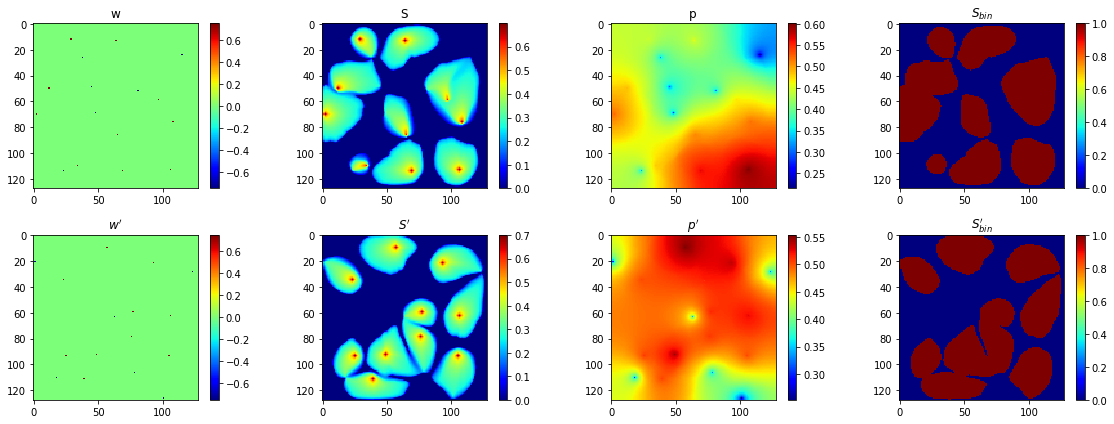

In [34]:
sat_threshold = 0.1
for k in range (2,3):
    plt.figure(figsize=(16, 6))
    #
    plt.subplot(2,4,1)
    plt.imshow(data_train_trial[k,...,0, 0])
    plt.title('w')
    plt.colorbar(fraction=0.046)
    #
    plt.subplot(2,4,2)
    plt.imshow(data_train_trial[k,...,1, 0])
    plt.title('S')
    plt.colorbar(fraction=0.046)
    #
    plt.subplot(2,4,3)
    plt.imshow(data_train_trial[k,...,2, 0])
    plt.title('p')
    plt.colorbar(fraction=0.046)
    #
    sat_bin = np.greater_equal(data_train_trial[k,...,1, 0], sat_threshold).astype(float)
    plt.subplot(2,4,4)
    plt.imshow(sat_bin)
    plt.title('$S_{bin}$')
    plt.colorbar(fraction=0.046)
    #
    plt.subplot(2,4,5)
    plt.imshow(data_train_trial[k,...,0, 1])
    plt.title('$w^{\prime}$')
    plt.colorbar(fraction=0.046)
    #
    plt.subplot(2,4,6)
    plt.imshow(data_train_trial[k,...,1, 1])
    plt.title('$S^{\prime}$')
    plt.colorbar(fraction=0.046)
    #
    plt.subplot(2,4,7)
    plt.imshow(data_train_trial[k,...,2, 1])
    plt.title('$p^{\prime}$')
    plt.colorbar(fraction=0.046)
    #
    sat_bin_prime = np.greater_equal(data_train_trial[k,...,1, 1], sat_threshold).astype(float)
    plt.subplot(2,4,8)
    plt.imshow(sat_bin_prime)
    plt.title('$S^{\prime}_{bin}$')
    plt.colorbar(fraction=0.046)
    
    plt.tight_layout()
    plt.show()

#### Re-organize data

In [8]:
# data_train_trial shape (?, 128, 128, 3, 2)
train_x_y_hat0 = data_train_trial[..., 0]# xc
train_y_hat0 = data_train_trial[..., [0], 1] #c
train_x_hat0 = data_train_trial[..., 1:, 1] # x

print(train_x_y_hat0.shape)
print(train_y_hat0.shape)
print(train_x_hat0.shape)

eval_x_y_hat0 = data_eval_trial[..., 0]# xc
eval_y_hat0 = data_eval_trial[..., [0], 1] #c
eval_x_hat0 = data_eval_trial[..., 1:, 1] # x

print(eval_x_y_hat0.shape)
print(eval_y_hat0.shape)
print(eval_x_hat0.shape)

# eval_x_y_hat0, eval_y_hat0, eval_x_hat0

(1800, 128, 128, 3)
(1800, 128, 128, 1)
(1800, 128, 128, 2)
(200, 128, 128, 3)
(200, 128, 128, 1)
(200, 128, 128, 2)


#### Train forward pass v-unet

In [9]:
input_shape = (128, 128, 3) # [S,p,w], the old saturation, pressure and well location
w_shape = (128, 128, 1) # [w'], the new well location and injection/production time
output_shape = (128, 128, 2) # [S', p'], the new saturation and pressure

reload if necessary

In [11]:
# from importlib import reload
# reload(vunet)

<module 'vunet_1' from '/data/cees/zjin/cs231n/project/var-unet/vunet_1.py'>

In [10]:
# change the role of enc_up and dec_up
# model specifications
n_res_block = 1
n_low_res = 6
n_scales = 5

enc_up, hidden_shapes = vunet.create_enc_up(input_shape, n_scales = n_scales)
enc_down = vunet.create_enc_down(hidden_shapes[-1])
dec_up = vunet.create_dec_up(w_shape, n_scales = n_scales) # only c input
dec_down = vunet.create_dec_down(hidden_shapes, hidden_shapes[-1], output_shape, n_scales = n_scales,  n_low_res = n_low_res)

In [11]:
# save inital weights
enc_up.save_weights(output_dir + 'enc_up_norm_init_' + case_string + '.h5' )
enc_down.save_weights(output_dir + 'enc_down_norm_init_' + case_string + '.h5' )
dec_up.save_weights(output_dir + 'dec_up_norm_init_' + case_string + '.h5' )
dec_down.save_weights(output_dir + 'dec_down_norm_init_' + case_string + '.h5' )

In [12]:
xc = Input(shape=input_shape) # perm + well location
c = Input(shape=w_shape) # well location

hs = enc_up(xc)
z_posterior_sample, z_posterior_mean = enc_down(hs[-1])
gs = dec_up(c)
x_hat, z_piror_sample, z_piror_mean = dec_down([z_posterior_mean, *gs])

In [35]:
def likelihood_loss(x, x_hat):
    '''
    Reconstruction loss, L2 norm
    '''
    
    v = 0.1
    return K.mean(K.sum((K.batch_flatten(x) - K.batch_flatten(x_hat)) ** 2 / (2*v), axis=-1))

def bce_loss(x, x_hat, s_cut=0.1):
    '''
    binary cross entropy loss, for saturation
    
    x shape: (?, 128, 128, 2)
    s_cut: saturation threshold: 0.1
    '''
    
    _, nx, ny, _ = x.shape

    sat = K.reshape(x[..., 0], (-1, nx*ny)) # shape (?, 128x128)
    sat_hat = K.reshape(x_hat[..., 0], (-1, nx*ny))
    
#     print(sat.shape)
    
    sat_bin = K.cast(K.greater_equal(sat, s_cut), dtype=K.floatx()) # greater_equal() returns boolean values, 
    sat_hat_bin = K.cast(K.greater_equal(sat_hat, s_cut), dtype=K.floatx()) # K.cast converts boolean to (0, 1)
    binary_loss = losses.binary_crossentropy(sat_bin, sat_hat_bin)
    
#     print(binary_loss.shape)
    
    return K.mean(binary_loss)

def flux_loss():
    pass

def latent_kl_loss(q, p):
    mean1 = q
    mean2 = p
    
    kl = 0.5 * (mean2 - mean1)**2
    kl = K.sum(kl, axis = [1,2,3])
    kl = K.mean(kl)
    return kl

In [43]:
x = Input(shape=output_shape) # target saturation, pressure

likelihood_ls = likelihood_loss(x, x_hat)

bce_ls = bce_loss(x, x_hat, sat_threshold)
kl_ls = latent_kl_loss(z_posterior_mean, z_piror_mean)

kl_weight = 5.0
bce_weight = 20.0

total_loss = likelihood_ls+ kl_weight * kl_ls + bce_weight* bce_ls


## Re-train start here

In [44]:
epoch = 40
learning_rate = 5e-4 # default 1e-3
decay = 1e-5 # default 1e-5
train_nr = data_train_trial.shape[0]
eval_nr = data_eval_trial.shape[0]

print('train_nr: ', train_nr)
print('eval_nr: ', eval_nr)

batch_size = 16
num_batch = int(train_nr/batch_size) 

print('num_batch: ', num_batch)


train_nr:  1800
eval_nr:  200
num_batch:  112


In [45]:
# in case of re-training, load initial weights
enc_up.load_weights(output_dir + 'enc_up_norm_init_' + case_string + '.h5')
enc_down.load_weights(output_dir + 'enc_down_norm_init_' + case_string + '.h5')
dec_up.load_weights(output_dir + 'dec_up_norm_init_' + case_string + '.h5')
dec_down.load_weights(output_dir + 'dec_down_norm_init_' + case_string + '.h5')

In [46]:
opt = Adam(lr=learning_rate, decay=decay)

trainable_weights = enc_up.trainable_weights + enc_down.trainable_weights + dec_up.trainable_weights + dec_down.trainable_weights

updates = opt.get_updates(total_loss, trainable_weights)

iterate = K.function([xc, c, x], [total_loss, likelihood_ls, kl_weight*kl_ls, bce_weight*bce_ls], updates=updates)

eval_loss = K.function([xc, c, x], [total_loss])


In [47]:
## used to generate log directory
currentDT = datetime.datetime.now()
current_time = str(currentDT).replace(" ", "-")[:-10]
print(current_time)

2019-05-24-12:42


In [48]:
## log for tensorboard
case_suffix = 'bce'

def write_summary(value, tag, summary_writer, global_step):
    """
    Write a single summary value to tensorboard
    """
    summary = tf.Summary()
    summary.value.add(tag=tag, simple_value=value)
    summary_writer.add_summary(summary, global_step)

    
summary_writer = tf.summary.FileWriter('logs/' + model_string + '_norm_lr%.0e_ep%d_'%(learning_rate, epoch)  + current_time + '_' + case_suffix)

In [49]:
for e in range(epoch):
    for ib in range(num_batch):
        ind0 = ib * batch_size
        n_itr = e * train_nr + ind0 + batch_size # for tensorboard output
        
        x_y_hat0_batch = train_x_y_hat0[ind0:ind0+batch_size, ...] #xc
        y_hat0_batch = train_y_hat0[ind0:ind0+batch_size, ...] # c: shape
        x_hat0_batch = train_x_hat0[ind0:ind0+batch_size, ...] # x
        
        train_losses = iterate([x_y_hat0_batch, y_hat0_batch, x_hat0_batch])
        ## -- K.function()
        ## -- Equivalent to:
        # train_losses = tf.session.run(feed_dict={xc: x_y_hat0_batch, c: y_hat0_batch, x: x_hat0_batch}, ...
        #                               fetches= [total_loss, likelihood_loss_value, kl_loss])
        # But output tensor for the updates operation is not returned.
        # For session.run(), the fetches should include a 'update' tensor, 
        # which is a tf operator that updates weights for each iteration.
        # Specifically, the 'update' tensor is defined as:
        # ---------------------------------
        # params = tf.trainable_variables()
        # gradients = tf.gradients(loss, params)
        # opt = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)
        # update = opt.apply_gradients(zip(gradients, params), global_step=global_step)
        # ---------------------------------
        # session.run() is with tf, and does not require Keras
        # K.function is a Keras API, which is more convient

        if ib % 10 == 0:
            print('Epoch %d/%d, Batch %d/%d, Total Loss %f, Likelihood Loss %f, KL Loss %f BCE Loss %f' % (e+1, epoch, ib+1, num_batch, train_losses[0], train_losses[1], train_losses[2], train_losses[3]))
            write_summary(train_losses[0], 'train_loss', summary_writer, n_itr) # log for tensorboard
    
    eval_losses = eval_loss([eval_x_y_hat0, eval_y_hat0, eval_x_hat0])    
    write_summary(eval_losses[0], 'eval_loss', summary_writer, n_itr) # log for tensorboard
        

    print('====================================================')
    print('\n')
    print('Epoch %d/%d, Train Total Loss %f, Eval Total Loss %f' % (e + 1, epoch, train_losses[0], eval_losses[0]))
    print('\n')
    print('====================================================')

    
enc_up.save_weights(output_dir + 'enc_up_norm_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
enc_down.save_weights(output_dir + 'enc_down_norm_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
dec_up.save_weights(output_dir + 'dec_up_norm_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))
dec_down.save_weights(output_dir + 'dec_down_norm_' + case_string + '_%dtrain_lr%.0e_ep%d.h5' % (train_nr, learning_rate, epoch))

Epoch 1/45, Batch 1/112, Total Loss 19506.890625, Likelihood Loss 19365.582031, KL Loss 14.463354 BCE Loss 126.845284
Epoch 1/45, Batch 11/112, Total Loss 7736.666016, Likelihood Loss 7616.401367, KL Loss 4.870063 BCE Loss 115.394478
Epoch 1/45, Batch 21/112, Total Loss 3264.909912, Likelihood Loss 3097.185059, KL Loss 7.567570 BCE Loss 160.157196
Epoch 1/45, Batch 31/112, Total Loss 3183.776367, Likelihood Loss 2999.178711, KL Loss 8.529171 BCE Loss 176.068695
Epoch 1/45, Batch 41/112, Total Loss 2806.282471, Likelihood Loss 2622.833008, KL Loss 10.462835 BCE Loss 172.986633
Epoch 1/45, Batch 51/112, Total Loss 2757.025635, Likelihood Loss 2581.935547, KL Loss 10.307081 BCE Loss 164.782867
Epoch 1/45, Batch 61/112, Total Loss 2909.840820, Likelihood Loss 2717.309570, KL Loss 8.149203 BCE Loss 184.382156
Epoch 1/45, Batch 71/112, Total Loss 2885.978271, Likelihood Loss 2705.555664, KL Loss 8.308352 BCE Loss 172.114166
Epoch 1/45, Batch 81/112, Total Loss 3250.423828, Likelihood Loss 31

Epoch 6/45, Batch 41/112, Total Loss 1204.230713, Likelihood Loss 1133.880615, KL Loss 6.955428 BCE Loss 63.394642
Epoch 6/45, Batch 51/112, Total Loss 1387.118408, Likelihood Loss 1313.727417, KL Loss 7.158430 BCE Loss 66.232498
Epoch 6/45, Batch 61/112, Total Loss 1100.209473, Likelihood Loss 1041.442993, KL Loss 5.333616 BCE Loss 53.432861
Epoch 6/45, Batch 71/112, Total Loss 1219.803711, Likelihood Loss 1150.436523, KL Loss 5.640054 BCE Loss 63.727135
Epoch 6/45, Batch 81/112, Total Loss 1441.986572, Likelihood Loss 1381.134521, KL Loss 5.221828 BCE Loss 55.630234
Epoch 6/45, Batch 91/112, Total Loss 1366.825684, Likelihood Loss 1292.571167, KL Loss 7.432737 BCE Loss 66.821838
Epoch 6/45, Batch 101/112, Total Loss 1224.361572, Likelihood Loss 1150.896729, KL Loss 7.772955 BCE Loss 65.691856
Epoch 6/45, Batch 111/112, Total Loss 1201.639404, Likelihood Loss 1134.419922, KL Loss 4.667620 BCE Loss 62.551838


Epoch 6/45, Train Total Loss 1382.757690, Eval Total Loss 1274.125977


Epoc

Epoch 11/45, Batch 81/112, Total Loss 685.848083, Likelihood Loss 651.859863, KL Loss 4.992301 BCE Loss 28.995916
Epoch 11/45, Batch 91/112, Total Loss 543.753601, Likelihood Loss 500.295776, KL Loss 8.040398 BCE Loss 35.417412
Epoch 11/45, Batch 101/112, Total Loss 539.520813, Likelihood Loss 497.895782, KL Loss 8.187437 BCE Loss 33.437584
Epoch 11/45, Batch 111/112, Total Loss 509.224060, Likelihood Loss 471.023804, KL Loss 6.242535 BCE Loss 31.957731


Epoch 11/45, Train Total Loss 555.115845, Eval Total Loss 672.514832


Epoch 12/45, Batch 1/112, Total Loss 498.914764, Likelihood Loss 463.908630, KL Loss 5.037532 BCE Loss 29.968609
Epoch 12/45, Batch 11/112, Total Loss 481.183411, Likelihood Loss 447.055603, KL Loss 5.702752 BCE Loss 28.425034
Epoch 12/45, Batch 21/112, Total Loss 558.902344, Likelihood Loss 516.832764, KL Loss 7.214306 BCE Loss 34.855289
Epoch 12/45, Batch 31/112, Total Loss 588.012207, Likelihood Loss 547.864136, KL Loss 6.855248 BCE Loss 33.292862
Epoch 12/45, B



Epoch 16/45, Train Total Loss 433.325378, Eval Total Loss 591.787781


Epoch 17/45, Batch 1/112, Total Loss 404.086334, Likelihood Loss 369.553101, KL Loss 6.794382 BCE Loss 27.738867
Epoch 17/45, Batch 11/112, Total Loss 339.754364, Likelihood Loss 311.420380, KL Loss 6.112149 BCE Loss 22.221823
Epoch 17/45, Batch 21/112, Total Loss 348.813141, Likelihood Loss 317.149841, KL Loss 8.405937 BCE Loss 23.257353
Epoch 17/45, Batch 31/112, Total Loss 368.063568, Likelihood Loss 335.445312, KL Loss 8.285504 BCE Loss 24.332771
Epoch 17/45, Batch 41/112, Total Loss 372.978729, Likelihood Loss 340.834717, KL Loss 7.472956 BCE Loss 24.671043
Epoch 17/45, Batch 51/112, Total Loss 371.503510, Likelihood Loss 337.809906, KL Loss 8.336212 BCE Loss 25.357389
Epoch 17/45, Batch 61/112, Total Loss 369.667877, Likelihood Loss 339.474609, KL Loss 6.650887 BCE Loss 23.542376
Epoch 17/45, Batch 71/112, Total Loss 390.360809, Likelihood Loss 358.524689, KL Loss 6.899207 BCE Loss 24.936914
Epoch 17/45, Bat

Epoch 22/45, Batch 31/112, Total Loss 369.608307, Likelihood Loss 339.432556, KL Loss 7.508883 BCE Loss 22.666862
Epoch 22/45, Batch 41/112, Total Loss 272.403992, Likelihood Loss 245.903107, KL Loss 7.071819 BCE Loss 19.429068
Epoch 22/45, Batch 51/112, Total Loss 355.274384, Likelihood Loss 325.263245, KL Loss 7.724239 BCE Loss 22.286901
Epoch 22/45, Batch 61/112, Total Loss 253.216187, Likelihood Loss 227.925583, KL Loss 6.310208 BCE Loss 18.980400
Epoch 22/45, Batch 71/112, Total Loss 301.311768, Likelihood Loss 276.251282, KL Loss 6.729064 BCE Loss 18.331417
Epoch 22/45, Batch 81/112, Total Loss 291.560364, Likelihood Loss 267.473907, KL Loss 5.071016 BCE Loss 19.015434
Epoch 22/45, Batch 91/112, Total Loss 253.761444, Likelihood Loss 228.117310, KL Loss 6.880929 BCE Loss 18.763191
Epoch 22/45, Batch 101/112, Total Loss 292.987762, Likelihood Loss 264.662048, KL Loss 8.980976 BCE Loss 19.344727
Epoch 22/45, Batch 111/112, Total Loss 360.312500, Likelihood Loss 325.517212, KL Loss 

Epoch 27/45, Batch 71/112, Total Loss 216.107941, Likelihood Loss 196.205780, KL Loss 5.876830 BCE Loss 14.025324
Epoch 27/45, Batch 81/112, Total Loss 202.165009, Likelihood Loss 181.848480, KL Loss 5.308503 BCE Loss 15.008030
Epoch 27/45, Batch 91/112, Total Loss 230.659348, Likelihood Loss 206.215393, KL Loss 6.720186 BCE Loss 17.723776
Epoch 27/45, Batch 101/112, Total Loss 382.518188, Likelihood Loss 350.067993, KL Loss 7.425714 BCE Loss 25.024471
Epoch 27/45, Batch 111/112, Total Loss 255.116791, Likelihood Loss 229.476715, KL Loss 6.230129 BCE Loss 19.409943


Epoch 27/45, Train Total Loss 251.228271, Eval Total Loss 413.283447


Epoch 28/45, Batch 1/112, Total Loss 250.871841, Likelihood Loss 225.810852, KL Loss 5.795626 BCE Loss 19.265371
Epoch 28/45, Batch 11/112, Total Loss 258.815613, Likelihood Loss 232.364746, KL Loss 6.676832 BCE Loss 19.774035
Epoch 28/45, Batch 21/112, Total Loss 242.154404, Likelihood Loss 215.759857, KL Loss 7.764310 BCE Loss 18.630239
Epoch 28/45, B

Epoch 32/45, Batch 111/112, Total Loss 254.887665, Likelihood Loss 231.585114, KL Loss 7.208607 BCE Loss 16.093952


Epoch 32/45, Train Total Loss 225.094498, Eval Total Loss 386.817047


Epoch 33/45, Batch 1/112, Total Loss 207.861282, Likelihood Loss 188.004578, KL Loss 5.165883 BCE Loss 14.690821
Epoch 33/45, Batch 11/112, Total Loss 223.196732, Likelihood Loss 202.698090, KL Loss 5.522940 BCE Loss 14.975702
Epoch 33/45, Batch 21/112, Total Loss 201.143402, Likelihood Loss 179.861176, KL Loss 6.654659 BCE Loss 14.627569
Epoch 33/45, Batch 31/112, Total Loss 267.432678, Likelihood Loss 240.943283, KL Loss 7.349330 BCE Loss 19.140051
Epoch 33/45, Batch 41/112, Total Loss 273.340637, Likelihood Loss 244.781677, KL Loss 7.133039 BCE Loss 21.425911
Epoch 33/45, Batch 51/112, Total Loss 224.559540, Likelihood Loss 200.069458, KL Loss 7.636318 BCE Loss 16.853752
Epoch 33/45, Batch 61/112, Total Loss 183.163452, Likelihood Loss 161.446365, KL Loss 5.968953 BCE Loss 15.748146
Epoch 33/45, Ba

Epoch 38/45, Batch 21/112, Total Loss 314.186310, Likelihood Loss 290.562622, KL Loss 8.214139 BCE Loss 15.409541
Epoch 38/45, Batch 31/112, Total Loss 238.686249, Likelihood Loss 216.248474, KL Loss 7.831635 BCE Loss 14.606142
Epoch 38/45, Batch 41/112, Total Loss 267.273651, Likelihood Loss 242.931122, KL Loss 7.901344 BCE Loss 16.441204
Epoch 38/45, Batch 51/112, Total Loss 197.746002, Likelihood Loss 176.337234, KL Loss 7.367000 BCE Loss 14.041771
Epoch 38/45, Batch 61/112, Total Loss 183.180374, Likelihood Loss 162.362503, KL Loss 6.525754 BCE Loss 14.292109
Epoch 38/45, Batch 71/112, Total Loss 162.158905, Likelihood Loss 142.986023, KL Loss 6.432736 BCE Loss 12.740149
Epoch 38/45, Batch 81/112, Total Loss 205.852005, Likelihood Loss 183.906860, KL Loss 5.506546 BCE Loss 16.438597
Epoch 38/45, Batch 91/112, Total Loss 177.011932, Likelihood Loss 155.170990, KL Loss 7.417133 BCE Loss 14.423807
Epoch 38/45, Batch 101/112, Total Loss 195.741348, Likelihood Loss 171.708160, KL Loss 8

Epoch 43/45, Batch 61/112, Total Loss 367.325592, Likelihood Loss 344.176880, KL Loss 6.630751 BCE Loss 16.517971
Epoch 43/45, Batch 71/112, Total Loss 269.197418, Likelihood Loss 241.558075, KL Loss 8.685301 BCE Loss 18.954035
Epoch 43/45, Batch 81/112, Total Loss 200.579102, Likelihood Loss 180.338379, KL Loss 6.407838 BCE Loss 13.832891
Epoch 43/45, Batch 91/112, Total Loss 224.050949, Likelihood Loss 200.750458, KL Loss 8.006475 BCE Loss 15.294027
Epoch 43/45, Batch 101/112, Total Loss 229.985962, Likelihood Loss 206.758331, KL Loss 8.947889 BCE Loss 14.279737
Epoch 43/45, Batch 111/112, Total Loss 320.079926, Likelihood Loss 298.910065, KL Loss 6.753506 BCE Loss 14.416363


Epoch 43/45, Train Total Loss 299.883514, Eval Total Loss 383.120605


Epoch 44/45, Batch 1/112, Total Loss 260.788666, Likelihood Loss 238.519440, KL Loss 5.193412 BCE Loss 17.075827
Epoch 44/45, Batch 11/112, Total Loss 359.963989, Likelihood Loss 336.729187, KL Loss 6.089313 BCE Loss 17.145477
Epoch 44/45, B